## Training

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from models import NaimishNet

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
net = NaimishNet()

### Dataloader

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

In [4]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [5]:
batch_size = 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

### Loss and optimization

In [6]:
# criterion = nn.NLLLoss()
criterion = nn.SmoothL1Loss()

# optimizer = optim.RMSprop(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Training function

In [7]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Training Finished !!')


In [22]:
# train your network
n_epochs = 1 # just 1 epoch to test

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.002622978061437607
Epoch: 1, Batch: 20, Avg. Loss: 0.0013562071397900581
Epoch: 1, Batch: 30, Avg. Loss: 0.001243504747748375
Epoch: 1, Batch: 40, Avg. Loss: 0.0012086029127240181
Epoch: 1, Batch: 50, Avg. Loss: 0.0011096812188625335
Epoch: 1, Batch: 60, Avg. Loss: 0.0010821009129285812
Epoch: 1, Batch: 70, Avg. Loss: 0.0010998713597655295
Epoch: 1, Batch: 80, Avg. Loss: 0.0010478428527712822
Training Finished !!


### Test data

In [15]:
from helpers import netSampleOutput, showAllKeypoints, visualizeOutput

In [13]:
test_images, test_outputs, gt_pts = netSampleOutput(net, test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 224, 224])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


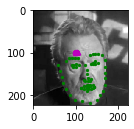

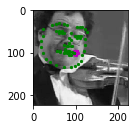

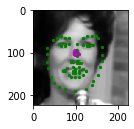

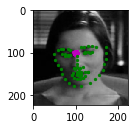

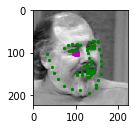

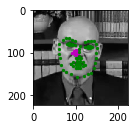

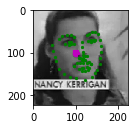

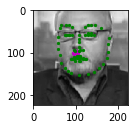

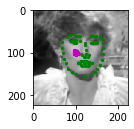

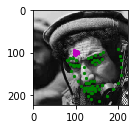

In [16]:
visualizeOutput(test_images, test_outputs, gt_pts)

In [18]:
#Save the model
model_dir = 'saved_models/'
model_name = 'naimish_model_1epoch_test.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

### Feature Visualization

In [23]:
import matplotlib.pyplot as plt
import numpy as np

[[-0.22329026  0.05624053  0.07629228 -0.12072712]
 [-0.1198298   0.06936729 -0.10624871  0.12348571]
 [ 0.10021952  0.1639829  -0.10478252 -0.06292161]
 [ 0.20601636  0.19929576  0.0398505   0.23629302]]
(4, 4)


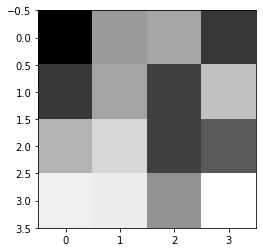

In [21]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 3

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

### Feature maps

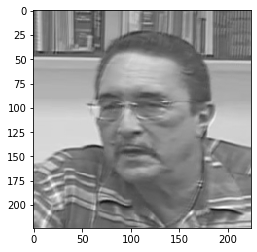

In [24]:
import cv2

idx_img = 13
img = np.squeeze(test_images[idx_img].data.numpy())
filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
plt.imshow(filtered_img, cmap="gray")